In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
import seaborn as sns
sns.set_style("white")
from sklearn.model_selection import train_test_split
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils import data
import logging
import random
from tensorboardX import SummaryWriter
from tqdm import tqdm
import torch.nn as nn
from collections import defaultdict

In [2]:
from image_processing import upsample
from data import prepare_data, TGSSaltDataset
from model import model_path, save_checkpoint, update_state, predict_tta
from resnet34_unet_hyper import UNetResNetSCSE
from training import train, test, RefineStep, RefineTestStep
from utils import tboard_log_path
from losses import lovasz_hinge
from metrics import my_iou_metric, iou_metric_batch
from visualisation import plot_poor_predictions, plot_predictions
from config import load_config, save_config, default_config_path

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
now = datetime.datetime.now()

In [ ]:
config_path=default_config_path()

In [5]:
config = load_config(config=config_path)["RefineModel"]
logger.info(f"Loading config {json.dumps(config, indent=4)}")

INFO:config:Loading config ../configs/config.json
INFO:__main__:Loading config {'base_channels': 32, 'batch_size': 128, 'best_model_filename': 'best_lovasz_model.pth', 'epochs': 200, 'id': '99e6d379-569f-4554-bf37-afa6d1d2f4e4', 'img_target_size': 128, 'initial_model_filename': 'best_model_state.pth', 'model_filename': 'model_lovasz_state', 'name': 'RefineModel', 'num_workers': 0, 'optimization_config': {'learning_rate': 0.001, 'scheduler': {'lr_min': 0, 'num_cycles': 6, 'type': 'cosine'}, 'type': 'adam'}, 'seed': 42}


In [6]:
locals().update(config)

In [7]:
torch.backends.cudnn.benchmark = True
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_refine_{id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = SummaryWriter(log_dir=tboard_log)

INFO:__main__:Started 2018-10-10 11:55:52.190713
INFO:__main__:Writing TensorBoard logs to /mnt/models/logs/pytorch_resnet34_unet_hyper/47e5a5adcce6e44ef2fcdc4bfdaae3b406002342/log_refine_99e6d379-569f-4554-bf37-afa6d1d2f4e4


In [8]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [9]:
model = UNetResNetSCSE()

In [10]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info("n_params: {}".format(n_params))

INFO:__main__:n_params: 30689405


In [11]:
device = torch.device("cuda:0")
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UNetResNetSCSE(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm

In [12]:
model_dir = os.path.join(model_path(), f"{id}")
filename = os.path.join(model_dir, initial_model_filename)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

In [13]:
train_df, test_df = prepare_data()
train_df.head()

100%|██████████| 4000/4000 [00:01<00:00, 2361.03it/s]


,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [14]:
upsample_to = upsample(101, img_target_size)

In [15]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample_to).tolist()).reshape(
        -1, 1, img_target_size, img_target_size
    ),
    np.array(train_df.masks.map(upsample_to).tolist()).reshape(
        -1, 1, img_target_size, img_target_size
    ),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.1,
    stratify=train_df.coverage_class,
    random_state=seed,
)

In [16]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
x_train.shape

(7200, 1, 128, 128)

In [17]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [18]:
train_data_loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
)
val_data_loader = data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
)

In [19]:
state = {
    "state_dict": None,
    "optimizer": None,
    "epoch": 0,
    "val_iou": 0,
    "best_val_iou": 0,
    "best_epoch": 0,
}

In [20]:
metrics = (("iou", my_iou_metric(threshold=0)),)
loss_fn = lovasz_hinge
optimizer = torch.optim.Adam(
    model.parameters(), lr=optimization_config["learning_rate"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True, threshold=0.0001
)

In [21]:
step_func = RefineStep(
    loss_fn,
    scheduler,
    optimizer,
    summary_writer=summary_writer,
    metrics_func=metrics
)

test_step_func = RefineTestStep(loss_fn, summary_writer=summary_writer)

In [ ]:
lovasz_history = defaultdict(list)
for epoch in range(epochs):
    train_metrics = train(
        epoch, model, train_data_loader, step_func, summary_writer=summary_writer
    )

    val_metrics = test(
        epoch,
        model,
        val_data_loader,
        test_step_func,
        summary_writer=summary_writer
    )
    scheduler.step(np.mean(val_metrics["loss"]))
    state = update_state(
        state, epoch, "val_iou", np.mean(val_metrics["iou"]), model, optimizer
    )

    save_checkpoint(
        state,
        outdir=model_dir,
        model_filename=model_filename,
        best_model_filename=best_model_filename,
    )

    lovasz_history["epoch"].append(epoch)
    lovasz_history["train_loss"].append(np.mean(train_metrics["loss"]))
    lovasz_history["val_loss"].append(np.mean(val_metrics["loss"]))
    lovasz_history["train_iou"].append(np.mean(train_metrics["iou"]))
    lovasz_history["val_iou"].append(np.mean(val_metrics["iou"]))

INFO:training:Train 0
INFO:training:Epoch: 0,Train: loss 0.862,  IoU 0.623
INFO:training:Elapsed 48.86
INFO:training:Test 0
INFO:training:Epoch: 0,Val: loss 0.538, IoU 0.701 ** 
INFO:training:Elapsed 4.31
INFO:model:val_iou went from 0 to 0.7005859375000001 >:)
INFO:training:Train 1
INFO:training:Epoch: 1,Train: loss 0.514,  IoU 0.709
INFO:training:Elapsed 29.16
INFO:training:Test 1
INFO:training:Epoch: 1,Val: loss 0.476, IoU 0.727 ** 
INFO:training:Elapsed 3.43
INFO:model:val_iou went from 0.7005859375000001 to 0.7267578125 >:)
INFO:training:Train 2
INFO:training:Epoch: 2,Train: loss 0.475,  IoU 0.729
INFO:training:Elapsed 28.87
INFO:training:Test 2
INFO:training:Epoch: 2,Val: loss 0.477, IoU 0.720 ** 
INFO:training:Elapsed 3.45
INFO:training:Train 3
INFO:training:Epoch: 3,Train: loss 0.459,  IoU 0.738
INFO:training:Elapsed 29.03
INFO:training:Test 3
INFO:training:Epoch: 3,Val: loss 0.883, IoU 0.695 ** 
INFO:training:Elapsed 3.41
INFO:training:Train 4
INFO:training:Epoch: 4,Train: los

Epoch    26: reducing learning rate of group 0 to 1.0000e-04.


INFO:training:Train 27
INFO:training:Epoch: 27,Train: loss 0.316,  IoU 0.808
INFO:training:Elapsed 28.82
INFO:training:Test 27
INFO:training:Epoch: 27,Val: loss 0.359, IoU 0.783 ** 
INFO:training:Elapsed 3.30
INFO:training:Train 28
INFO:training:Epoch: 28,Train: loss 0.288,  IoU 0.821
INFO:training:Elapsed 28.97
INFO:training:Test 28
INFO:training:Epoch: 28,Val: loss 0.350, IoU 0.796 ** 
INFO:training:Elapsed 3.30
INFO:training:Train 29
INFO:training:Epoch: 29,Train: loss 0.275,  IoU 0.828
INFO:training:Elapsed 28.78
INFO:training:Test 29
INFO:training:Epoch: 29,Val: loss 0.340, IoU 0.803 ** 
INFO:training:Elapsed 3.27
INFO:model:val_iou went from 0.7986328125000001 to 0.8031250000000001 >:)
INFO:training:Train 30
INFO:training:Epoch: 30,Train: loss 0.272,  IoU 0.830
INFO:training:Elapsed 29.06
INFO:training:Test 30
INFO:training:Epoch: 30,Val: loss 0.340, IoU 0.802 ** 
INFO:training:Elapsed 3.29
INFO:training:Train 31
INFO:training:Epoch: 31,Train: loss 0.265,  IoU 0.833
INFO:training

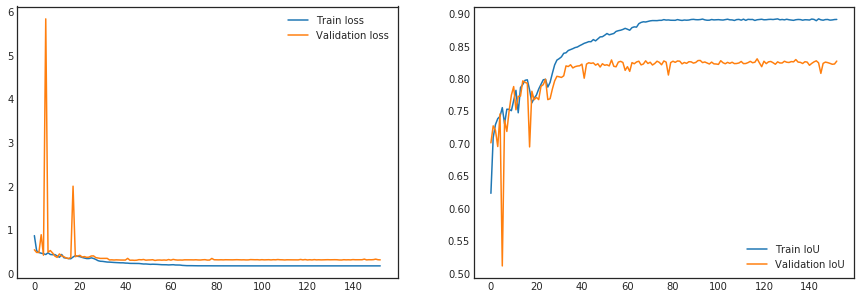

In [23]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.plot(lovasz_history["epoch"], lovasz_history["train_loss"], label="Train loss")
ax_loss.plot(
    lovasz_history["epoch"], lovasz_history["val_loss"], label="Validation loss"
)
ax_loss.legend()
ax_iou.plot(lovasz_history["epoch"], lovasz_history["train_iou"], label="Train IoU")
ax_iou.plot(lovasz_history["epoch"], lovasz_history["val_iou"], label="Validation IoU")
ax_iou.legend()

### Find Optimal Threshold

In [24]:
filename = os.path.join(model_dir, best_model_filename)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


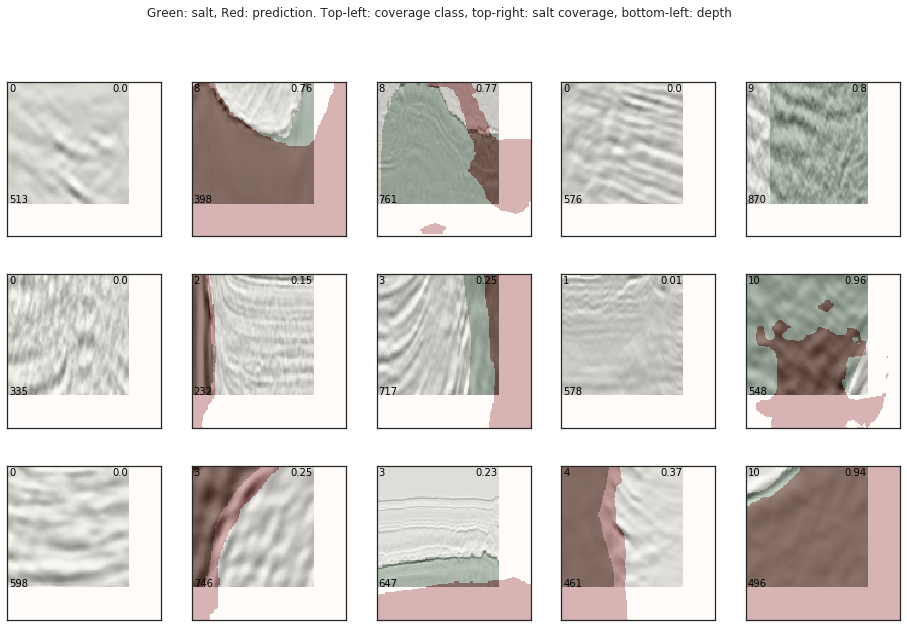

In [25]:
model.eval()
predictions = [predict_tta(model, image) for image, _ in tqdm(val_data_loader)]
preds_valid = np.concatenate(predictions, axis=0).squeeze()

preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > 0), dtype=np.float32), preds_valid
)

preds_thresh = np.array(list(preds_thresh_iter))


plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

In [26]:
## Scoring for last model, choose threshold using validation data
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = y_valid.squeeze()
thresholds = np.log(thresholds / (1 - thresholds))

ious = list(
    map(
        lambda th: iou_metric_batch(y_valid_down, np.int32(preds_valid > th)),
        tqdm(thresholds),
    )
)

threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


Text(0.5, 1.0, 'Threshold vs IoU (0.43332206261113065, 0.8280000000000001)')

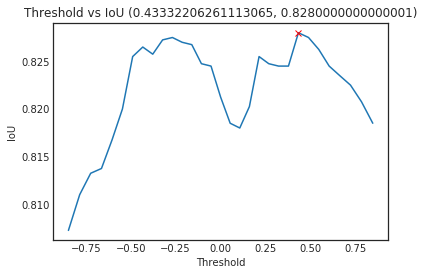

In [27]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))

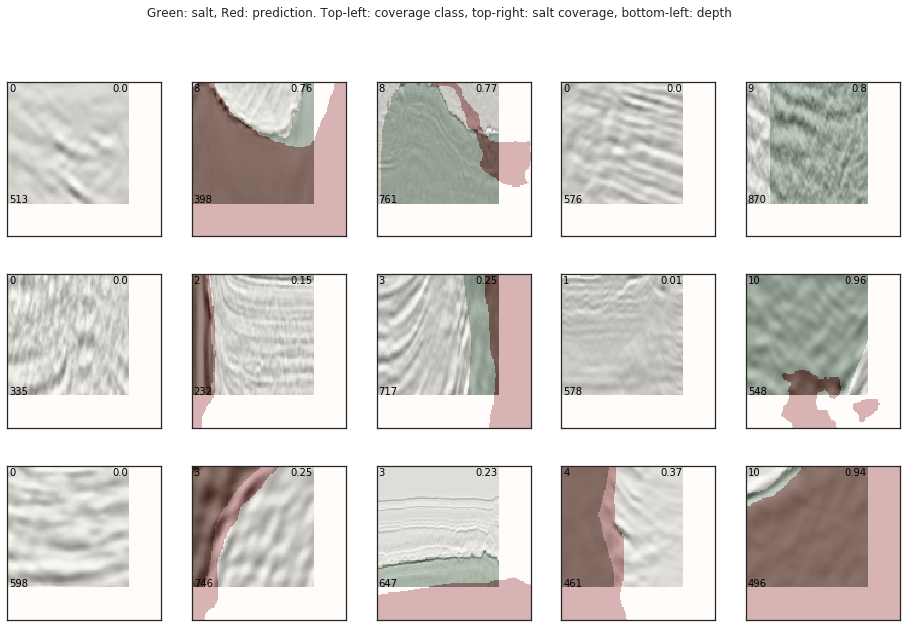

In [28]:
preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32),
    preds_valid,
)
preds_thresh = np.array(list(preds_thresh_iter))

plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

plt.legend()

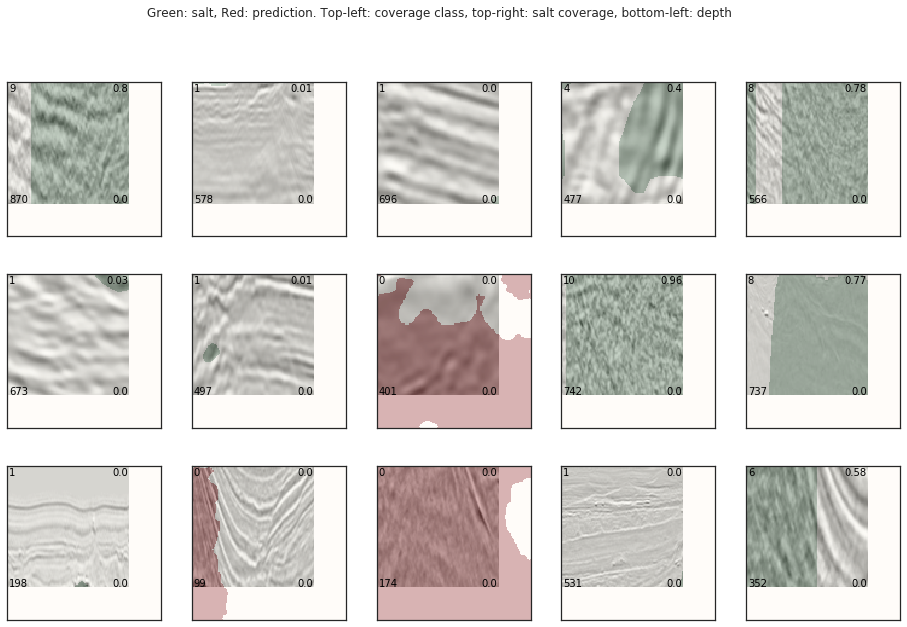

In [29]:
plot_poor_predictions(
    train_df,
    preds_thresh,
    y_valid_down,
    ids_valid,
    max_images=15,
    grid_width=5,
    figsize=(16, 10),
)

In [30]:
dd = train_df.loc[ids_valid]

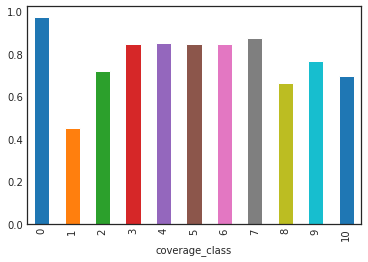

In [31]:
dd.groupby("coverage_class").mean().iou.plot(kind="bar")

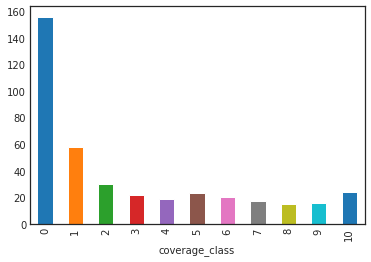

In [32]:
dd.groupby("coverage_class").count().z.plot(kind="bar")

In [33]:
dd["iou"].mean()

0.8112972344734996

In [34]:
# write best threshold to config
config = load_config()
config["EvaluateModel"]["threshold"] = threshold_best
save_config(config)

INFO:config:Loading config ../configs/config.json
INFO:config:Saving config ../configs/config.json
INFO:config:{
    "EvaluateModel": {
        "base_channels": 32,
        "batch_size": 128,
        "id": "99e6d379-569f-4554-bf37-afa6d1d2f4e4",
        "img_target_size": 128,
        "initial_model_filename": "best_lovasz_model.pth",
        "name": "EvaluateModel",
        "num_workers": 0,
        "seed": 42,
        "threshold": 0.43332206261113065
    },
    "Model": {
        "base_channels": 32,
        "batch_size": 128,
        "best_model_filename": "best_model_state.pth",
        "epochs": 70,
        "id": "99e6d379-569f-4554-bf37-afa6d1d2f4e4",
        "img_target_size": 128,
        "model_filename": "model_{cycle}_state.pth",
        "num_workers": 0,
        "optimization_config": {
            "base_lr": 0.05,
            "momentum": 0.9,
            "nesterov": true,
            "scheduler": {
                "lr_min": 0,
                "num_cycles": 6,
             